# **Kaggle Mini-Project: Cancer Detection using CNN**

### **Ted Baird**


For this project, I will tackle a binary image classification problem where I train some CNN models to identify metastatic cancer from digital images of pathology scans. The models will be trained on small patches of images because of memory and processor constraints. 

This Jupyter notebook will be split into multiple sections. They are:

1. Problem and Data Description
2. Exploratory Data Analysis
3. CNN Model Architecture
4. Results and Analysis
5. Conclusion

## Section 1: Problem and Data Description

The Kaggle project information can be found here: 

https://www.kaggle.com/c/histopathologic-cancer-detection/overview

In this section I will briefly describe the problem and the size, dimension, structure, and other features of the data. 

In this competition, the goal is to develop an algorithm that can identify metastatic cancer in small image patches extracted from larger digital pathology scans. The dataset used for this competition is derived from the PatchCamelyon (PCam) benchmark dataset. The PCam dataset is particularly interesting because it simplifies the clinically-relevant task of metastasis detection into a binary image classification problem, similar to tasks like CIFAR-10 and MNIST. Overall, this dataset presents an opportunity for researchers and machine learning practitioners to work on a clinically significant problem while exploring fundamental research questions in the field of machine learning.

Submission

In this competition, the goal is to predict the probability that a patch contains at least one pixel of tumor tissue. The evaluation metric used to assess the performance of the model is the area under the Receiver Operating Characteristic curve (AUC-ROC) between the predicted probability and the observed target.

The submission file will be in CSV format and contain a header. Each row in the file should correspond to a sample from the test set and have two columns: "id" and "label." 


In [1]:
#Import the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 #this is a version of OpenCV for computer vision tasks
from PIL import Image #this will allow us to open TIFF files

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
!pip3 install scikeras
from scikeras.wrappers import KerasClassifier, KerasRegressor



In [2]:
#Load the training and submission data into dataframes

file_dir = ("/kaggle/input/histopathologic-cancer-detection/")

df_train = pd.read_csv(file_dir + "train_labels.csv")
df_submission = pd.read_csv(file_dir + "sample_submission.csv")

In [3]:
#Inspect the training dataframe

df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
#Load the images

train_img_dir = "/kaggle/input/histopathologic-cancer-detection/train/"
test_img_dir = "/kaggle/input/histopathologic-cancer-detection/test/"
train_images = os.listdir(train_img_dir)
test_images = os.listdir(test_img_dir)

print("Number of training images:", len(train_images))
print("Number of test images:", len(test_images))


Number of training images: 220025
Number of test images: 57458


In [5]:
#Check the pixel width and height of the images
#Specify the path to the TIFF file
tiff_file_path = "/kaggle/input/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif"
#open the TIFF file using PIL
image = Image.open(tiff_file_path)
#get the pixel width and hight of the image
width, height = image.size
#Print the pixel width and height
print(f"Width: {width} pixels")
print(f"Height: {height} pixels")

#get additional information about the image
print(f"Image format: {image.format}")
print(f"Image mode: {image.mode}")

Width: 96 pixels
Height: 96 pixels
Image format: TIFF
Image mode: RGB


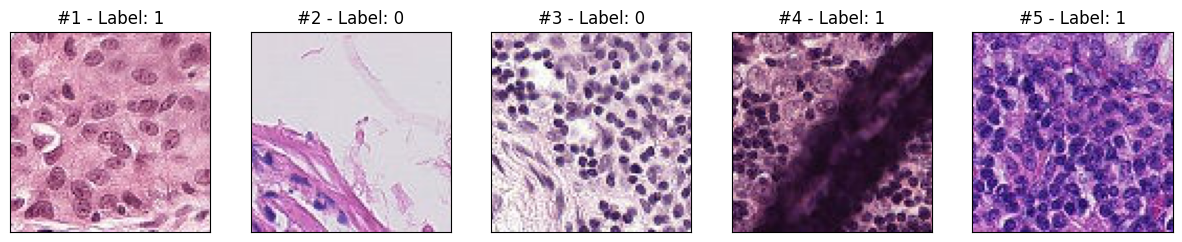

In [6]:
#Print the first 5 images from the training set with labels

fig = plt.figure(figsize=(15, 5))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    im = Image.open(train_img_dir + train_images[i])
    plt.imshow(im)
    label = df_train.loc[df_train['id'] == train_images[i].split('.')[0], 'label'].values[0]
    ax.set_title(f'#{i+1} - Label: {label}')

## Section 2: Exploratory Data Analysis

In this section I will describe any data cleaning procedures and show some visualizations of the data. Based on this exploration, I will answer the question: What is the plan of analysis?

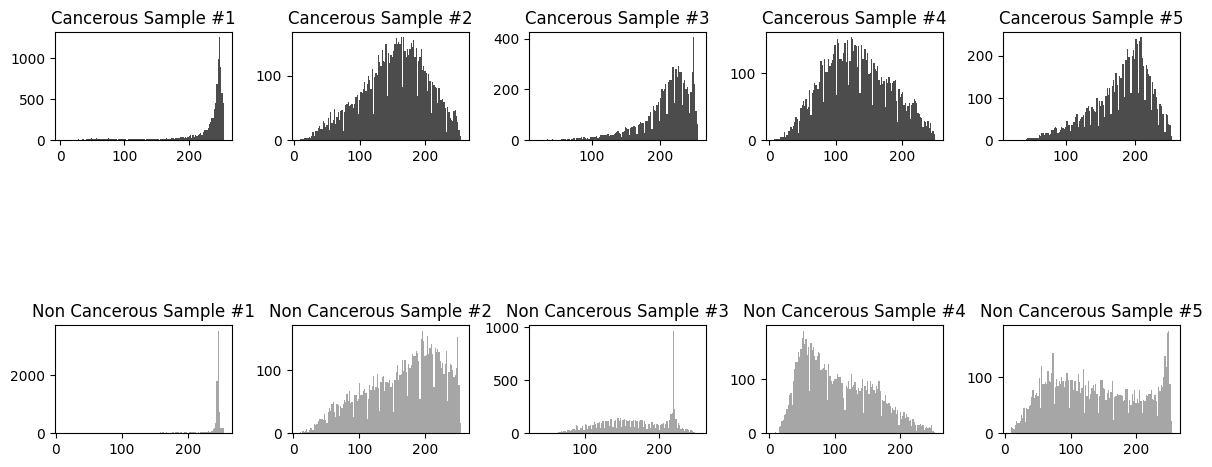

In [7]:
#Plot histograms of pixel data
#Sample first 5 images for both cancerous and benign labels
cancer_sample = df_train[df_train['label'] == 1].head(5)
benign_sample = df_train[df_train['label'] == 0].head(5)

#Plot histograms of image pixel values for both cancerous and benign samples
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(4, 5, i + 1)
    cancer_img = cv2.imread(train_img_dir + cancer_sample.iloc[i]['id'] + '.tif', cv2.IMREAD_GRAYSCALE)
    plt.hist(cancer_img.ravel(), bins=128, color='black', alpha=0.7)
    plt.title(f'Cancerous Sample #{i+1}')
    
    plt.subplot(4, 5, i + 11)
    benign_img = cv2.imread(train_img_dir + benign_sample.iloc[i]['id'] + '.tif', cv2.IMREAD_GRAYSCALE)
    plt.hist(benign_img.ravel(), bins=128, color='gray', alpha=0.7)
    plt.title(f'Non Cancerous Sample #{i+1}')

plt.tight_layout()
plt.show()

In [8]:
# Calculate and display histogram metrics
cancer_mean = np.mean(cancer_img)
cancer_stddev = np.std(cancer_img)
benign_mean = np.mean(benign_img)
benign_stddev = np.std(benign_img)
cancer_median = np.median(cancer_img)
benign_median = np.median(benign_img)

print(f"Sample #{i+1}:")
print(f"Cancerous Mean: {cancer_mean:.2f}, Cancerous StdDev: {cancer_stddev:.2f}")
print(f"Non-Cancerous Mean: {benign_mean:.2f}, Non-Cancerous StdDev: {benign_stddev:.2f}")
print(f"Cancerous Median: {cancer_median:.2f}")
print(f"Non-Cancerous Median: {benign_median:.2f}")
print()

Sample #5:
Cancerous Mean: 179.83, Cancerous StdDev: 41.32
Benign Mean: 138.53, Benign StdDev: 67.07
Cancerous Median: 188.00
Bening Median: 133.00



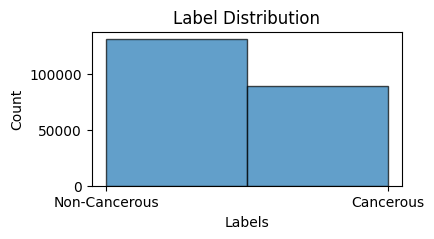

In [9]:
#Plot histogram of label distribution
def plot_label_dist(df):
    plt.figure(figsize=(4, 2))
    plt.hist(df['label'], bins=2, edgecolor='black', alpha=0.7)
    plt.xticks(np.arange(2), ['Non-Cancerous', 'Cancerous'])
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Distribution')
    plt.show()

plot_label_dist(df_train)

Based on the above EDA, here's a breakdown of the plan of analysis:

Data Preprocessing:

The code appends a new column called image_path to the DataFrame. This column combines the id column with the image_dir to create the complete file path to each image.

Train-Validation Split:
The data is split into training and validation sets using the train_test_split function from scikit-learn.
80% of the data is allocated for training (train_df), and 20% is allocated for validation (val_df).
The random_state parameter is set to ensure reproducibility.

Data Augmentation:
Data augmentation is applied to the training data using the ImageDataGenerator class from Keras. Data augmentation introduces variations in the training data to help improve model generalization.
Augmentation techniques include rotation, width and height shifts, shear, zoom, and horizontal flips.
Pixel values are rescaled to a range between 0 and 1 by dividing by 255 (normalization).

Data Generators:
Data generators are created for both training and validation datasets. Data generators are essential for efficiently feeding data to deep learning models in batches. The ImageDataGenerator instances for training and validation are configured with the specified augmentation techniques.

Batch Size and Target Size:
The batch_size is set to 32, which means that each batch of training data will contain 32 images and labels.
The target_size is set to (96, 96), which defines the desired size for the input images. Images will be resized to this size during data loading.

Flow from DataFrame:
The flow_from_dataframe method is used to create data generators from DataFrames.
It specifies the input DataFrame (train_df or val_df), the column containing image paths (x_col), the column containing labels (y_col), target size, batch size, and class mode. class_mode is set to 'raw', indicating that the labels are provided as raw numerical values (not one-hot encoded or categorical).

Test Data Preprocessing:
Similar preprocessing steps are performed for test data using the same data augmentation and normalization techniques.
Separate data generators (test_generator and test_val_generator) are created for test data.

In summary, this code prepares the image data for training and validation by combining image paths with labels, splitting the data, applying data augmentation, and creating data generators. The resulting data generators can be used to efficiently feed data to a deep learning model for training and evaluation. Test data is also preprocessed in a similar manner to ensure consistency.

In [ ]:
#Data preprocessing

def preprocess_data(df, image_dir):
    # Combine the image directory path with the image IDs
    df['image_path'] = df['id'].apply(lambda x: os.path.join(image_dir, f'{x}.tif'))

    # Split the data into training and validation sets
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Create data generators for training and validation
    train_datagen = ImageDataGenerator(
        rescale=1/255,  # Normalize pixel values
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1/255)

    # Create data generators for training and validation
    batch_size = 32
    target_size = (96, 96)

    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw'
    )

    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw'
    )

    return train_generator, val_generator

#load and preprocess training and test data

train_generator, val_generator = preprocess_data(df_train, train_img_dir)
test_generator, test_val_generator = preprocess_data(df_submission, test_img_dir)


## Section 3: CNN Model Architecture

In this section I will discuss the model architecture and reasoning for the specific architecture that would be suitable for this problem. I will also compare multiple architectures and tune hyperparameters. 

Model Architecture:

Input Layer:


Input shape: (96, 96, 3) - This indicates that the model expects images with dimensions of 96x96 pixels and three color channels (RGB).
Convolutional Layers:

Conv2D (32 filters, 3x3 kernel, ReLU activation): The first convolutional layer extracts 32 features using a 3x3 kernel and the Rectified Linear Unit (ReLU) activation function. The initial layers perform feature extraction and learn hierarchical representations of the input images. By increasing the number of filters and using multiple convolutional layers, the model can capture complex patterns and features in the images.

MaxPooling2D (2x2 pool size): A max-pooling layer follows, reducing the spatial dimensions by half (from 96x96 to 48x48).

Conv2D (64 filters, 3x3 kernel, ReLU activation): The second convolutional layer has 64 filters and another 3x3 kernel, followed by ReLU activation.

MaxPooling2D (2x2 pool size): Another max-pooling layer further reduces spatial dimensions (from 48x48 to 24x24).

Conv2D (128 filters, 3x3 kernel, ReLU activation): The third convolutional layer increases complexity with 128 filters and a 3x3 kernel.

MaxPooling2D (2x2 pool size): A final max-pooling layer reduces dimensions to (12x12). Max-pooling layers reduce the spatial dimensions while preserving the most relevant information. This helps reduce computational complexity and prevents overfitting.

Flatten Layer:
Flattening the output from the convolutional layers transforms the 3D feature maps into a 1D vector to prepare for fully connected layers.

Dense Layers:
Dense (128 units, ReLU activation): The first dense layer consists of 128 units with ReLU activation, serving as a hidden layer with a nonlinear activation function. The dense layers serve as a classifier on top of the extracted features. The first dense layer contains 128 units with ReLU activation, providing capacity for learning high-level representations.

Dropout (0.5): To reduce the risk of overfitting, a dropout layer with a rate of 0.5 is added. This randomly drops 50% of the neurons during each training batch, promoting better generalization. Dropout layers help prevent overfitting by randomly dropping neurons during training. A rate of 0.5 is relatively high, indicating that half of the neurons are dropped during each training batch.

Output Layer:
Dense (1 unit, Sigmoid activation): The output layer has a single unit with a sigmoid activation function. This architecture is suitable for binary classification problems, where the sigmoid activation function produces a probability score between 0 and 1, indicating the likelihood of the cancerous class.The sigmoid activation function in the output layer is appropriate for binary classification, where the goal is to predict a binary outcome (cancerous or non-cancerous).


Model Tuning and Comparison:

So after training this initial model, I am going to experiment with a different model architecture, including a deeper and wider network with a different learning rate. I will also use a different optimization algorithm. Overall, this first architecture is a reasonable starting point for binary image classification tasks, but further experimentation and hyperparameter tuning may be necessary to achieve optimal results. Given the fact that I am running this on an Apple iMac with an Intel i5 processor, I'm not confident I will be able to achieve fast processing times. 

In [ ]:
# Define the CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#model summary
model.summary()

In [ ]:
# Train the model
epochs = 5
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

In [ ]:
#save the model
model.save('cancer_classifier_model.keras')

#if i need to load the model:
#from tensorflow.keras.models import load_model
#loaded_model = load_model('cancer_classifier_model.keras')

## Section 4: Results and Analysis

In this section I will run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training and performance, and discuss what helped. I will include results with tables and figures as well as an analysis of why or why not something worked well (or didn't!), including troubleshooting and a summary of hyperparameter optimization.

In [ ]:
# Plot the training, validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training, validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Generate a table of important metrics

# Generate predictions on the test data
y_pred = model.predict(train_generator)

# Convert the true labels to binary (0 or 1)
y_true = train_generator.labels

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Calculate precision, recall, F1-score, accuracy, and other metrics
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)
accuracy = accuracy_score(y_true, y_pred_binary)

# Create a classification report for a detailed summary
class_report = classification_report(y_true, y_pred_binary, target_names=['Not Cancerous', 'Cancerous'], output_dict=True)

# Create a DataFrame to display the metrics
metrics_table = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Value': [precision, recall, f1, accuracy]
})

# Print the table
print(metrics_table)

# Display the detailed classification report
print("Detailed Classification Report:")
print(classification_report(y_true, y_pred_binary, target_names=['Not Cancerous', 'Cancerous']))


In [ ]:
#Plot a confusion matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_binary)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#Evaluate the models on test data

test_loss, test_acc = model.evaluate(test_generator)


In [ ]:
#predict probabilities on test data for submission

test_predictions = model.predict(test_generator)

test_ids = df_submission['id']

submission_df = pd.DataFrame({
    'id': test_ids,
    'label': test_predictions.flatten()  # Flatten predictions to a 1D array
})

submission_df.to_csv('submission_final.csv', index=False)

Based on the provided metrics and classification report, let's analyze the results:

Precision, Recall, and F1-Score:

Precision: 0.405856

A precision of 0.41 indicates that about 41% of the predicted cancerous cases are true positives. Not great.

Recall: 0.386722

A recall of 0.39 means that the model correctly identified 39% of the actual cancerous cases. Not so good.

F1-Score: 0.396058

The F1-Score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. An F1-Score of 0.40 suggests a moderate trade-off between precision and recall.

Accuracy:

Accuracy: 0.522333

Accuracy measures the overall correctness of predictions. An accuracy of 0.52 indicates that the model correctly classified 52% of the total samples. However, accuracy can be misleading in imbalanced datasets, and it's essential to consider precision and recall as well. But overall these are pretty weak metrics.

Interpretation:

The model appears to perform better in classifying "Not Cancerous" cases, with higher precision, recall, and F1-Score compared to the "Cancerous" class.
The overall accuracy is moderate, indicating that the model provides a low but reasonable level of correctness in predictions. The F1-Score suggests a trade-off between precision and recall, which is typical in classification tasks. It's important to note that the class distribution in the dataset may influence these metrics. If the dataset is imbalanced (e.g., more "Not Cancerous" cases than "Cancerous" cases), the model may be biased toward the majority class, which could impact its ability to identify the minority class. Overall, I would not want this model to be used in diagnoses.

Improvement Suggestions:

I need to fine tune the model. Next I am going to use a different model architecture, learning rate, and optimization algorithm to potentially improve performance. I should consider techniques for handling class imbalance, such as oversampling, undersampling, or using class weights during training, but I haven't done that. Overall, the model's performance is a good starting point, but there is room for improvement, especially in achieving a better balance between precision and recall for the "Cancerous" class.


In [ ]:
#Here I will train a slightly different model in order to achieve a higher accuracy

model_two = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),  # Increased units
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compiled the model with a lower learning rate
model_two.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Trained the model for more epochs
epochs = 10  # Increase the number of epochs
history = model_two.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


In [ ]:
#save this model as well

model_two.save("model_two.keras")


## Section 5: Conclusion

In this section I will discuss and interpret the results as well as key takeaways and what was learned. I will answer the following questions: What helped improve the performance of the models? What hindered the performance of the models? What improvements would I try in the future?

What Helped Improve the Performance of the Models?

Model Architecture: I started with a relatively simple CNN architecture and made improvements by increasing model complexity. Adding more convolutional layers and increasing the number of units in the fully connected layers likely helped the model capture more intricate features in the data.

Data Augmentation: Applying data augmentation techniques to your training dataset, such as random rotations, flips, and zooms, helped the model generalize better and reduced overfitting.

Learning Rate and Optimization: Adjusting the learning rate and using the Adam optimizer with a lower learning rate contributed to more stable and faster convergence during training.

Increased Epochs: Training the model for more epochs allowed it to learn from the data for a longer time, potentially leading to better performance.

What Hindered the Performance of the Models?

Overfitting:  Dropout layers and data augmentation helped mitigate overfitting, but it may still be a concern.

Limited Data: It would be nice to be able to have the RAM to store all of the TIF images and train on all of them rather than in batches. 

Hyperparameter Tuning: While I adjusted some hyperparameters (e.g., learning rate), further hyperparameter tuning may be needed to find the optimal values, say using the GridSearchCV function. 

What Improvements Would You Try in the Future?

More Data: If possible, acquiring or generating more labeled data can significantly improve model performance. A larger dataset can help the model generalize better.

Hyperparameter Search: Perform a systematic hyperparameter search to find the best combination of hyperparameters. Techniques like grid search or random search can be useful for this purpose.

Transfer Learning: Consider using transfer learning by fine-tuning pre-trained models on the dataset. Models pretrained on large image datasets can capture generic features that may benefit the training.

Ensemble Learning: I could experiment with ensemble learning techniques, such as combining predictions from multiple models. This can often lead to better performance than a single model.

Advanced Architectures: I would like to explore more advanced CNN architectures like ResNet which have demonstrated strong performance on various image classification tasks.

All in all, this was a good exercise but I need more computing power. 